# Replication Study: Dissecting racial bias in an algorithm used to manage the health of populations

## Abstract


This analysis explores the racial bias present in a healthcare algorithm that disproportionately affected Black patients by underestimating their healthcare needs. By reproducing key visualizations from Obermeyer et al.'s groundbreaking 2019 paper, I confirm that at equivalent risk scores, Black patients exhibit significantly more chronic conditions than White patients, yet they incur lower healthcare costs. Using polynomial regression modeling on standardized data, I find that Black patients generate approximately 18.9% less in healthcare costs than White patients with equivalent health needs. These findings suggest that using healthcare costs as a proxy for health needs fundamentally encodes racial disparities into the algorithm. This case exemplifies calibration bias in classification algorithms, where equal predictions across groups mask significant disparities in outcomes.

# Part A: Data Access

In [1]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

# Part B: Reproduce Fig. 1

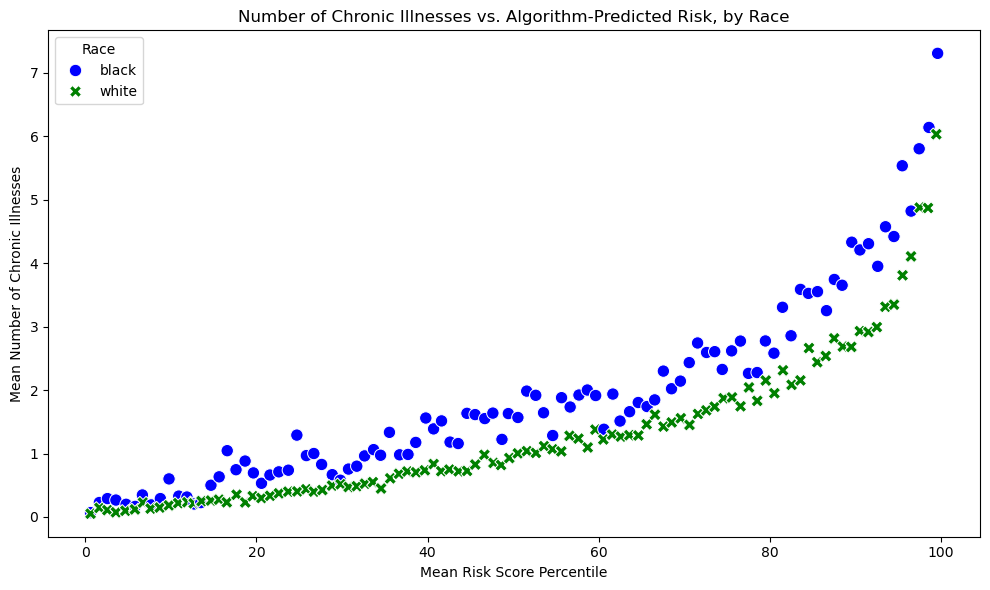

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for patients who self-report as 'white' or 'black'
df = df[df['race'].isin(['white', 'black'])]

# Compute each patient's risk score percentile
df['risk_percentile'] = df['risk_score_t'].rank(pct=True) * 100

# Create risk score bins using 100 percentile groups
df['risk_percentile_bin'] = pd.qcut(df['risk_score_t'], q=100, labels=False, duplicates='drop')

# Group the data by risk_percentile_bin and race,
# computing the mean risk percentile and the mean number of chronic illnesses for each bin
grouped = df.groupby(['risk_percentile_bin', 'race']).agg(
    mean_risk_percentile=('risk_percentile', 'mean'),
    mean_chronic=('gagne_sum_t', 'mean')
).reset_index()

# Plot the aggregated data
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x='mean_risk_percentile',
    y='mean_chronic',
    hue='race',
    style='race',
    markers={'white': 'X', 'black': 'o'},
    palette={'white': 'green', 'black': 'blue'},
    s=80
)
plt.xlabel("Mean Risk Score Percentile")
plt.ylabel("Mean Number of Chronic Illnesses")
plt.title("Number of Chronic Illnesses vs. Algorithm-Predicted Risk, by Race")
plt.legend(title="Race")
plt.tight_layout()
plt.show()

This visualization reproduces the key finding from Obermeyer et al.'s paper: at the same level of algorithm-predicted risk, Black patients consistently have more chronic illnesses than White patients. This disparity widens as the risk score increases, becoming particularly pronounced at higher risk percentiles.
If Patient A (Black) and Patient B (White) have exactly the same chronic illnesses, they would not be equally likely to be referred to the high-risk care management program. The data clearly shows that the algorithm would assign Patient A a lower risk score than Patient B despite their identical health conditions, making Patient A less likely to receive additional care. This bias is especially concerning because the 97th percentile was used as an automatic enrollment threshold for the program.

# Part C: Reproduce Fig. 3

## 1. Panel A: Expenditures by Risk Score Percentile


First, we divide the risk scores into 100 quantile bins. By using `pd.qcut()`, we ensure an approximately equal number of patients in each bin, which helps create a more balanced visualization. The `duplicates='drop'` parameter ensures we handle any tied values properly. Next, we aggregate the data by both risk percentile bin and race, calculating the mean risk percentile and mean expenditures for each group. This summarization allows us to visualize how costs vary across different risk levels for each racial group. We also count the unique bins to understand how many distinct groups we've created.

In [3]:
# Create 100 bins based on the raw risk scores using qcut
df['risk_percentile_bin'] = pd.qcut(df['risk_score_t'], q=100, labels=False, duplicates='drop')

# Group by these bins and race to compute the mean risk percentile and mean expenditures
panelA = df.groupby(['risk_percentile_bin', 'race']).agg(
    mean_risk_percentile=('risk_percentile', 'mean'),
    mean_expenditures=('cost_t', 'mean')
).reset_index()

# Check how many unique bins actually got created
num_bins_A = df['risk_percentile_bin'].nunique()

## 2. Panel B: Expenditures by Chronic Conditions

For the second panel, we repeat a similar process but focusing on chronic conditions rather than risk scores. We create 100 quantile bins based on the number of chronic conditions (`gagne_sum_t`), then aggregate the data to calculate mean chronic conditions and mean expenditures for each bin and race. This allows us to compare how healthcare costs vary with illness burden across racial groups.

In [4]:
df['chronic_bin'] = pd.qcut(df['gagne_sum_t'], q=100, labels=False, duplicates='drop')

# Group by these bins and race to compute the mean number of chronic conditions and mean expenditures
panelB = df.groupby(['chronic_bin', 'race']).agg(
    mean_chronic=('gagne_sum_t', 'mean'),
    mean_expenditures=('cost_t', 'mean')
).reset_index()

# Check how many unique bins were created for chronic conditions
num_bins_B = df['chronic_bin'].nunique()

## 3. Plotting Both Panels Side by Side


With our aggregated data, we now create a two-panel figure. For Panel A, we visualize the relationship between risk scores and healthcare expenditures. We use distinctive markers and colors to differentiate between racial groups. By inverting the x-axis, higher risk percentiles appear on the left, matching the original paper's presentation and making it easier to focus on the highest-risk patients.

For Panel B, we construct the second visualization showing the relationship between chronic conditions and healthcare expenditures. Using the same styling approach as Panel A ensures visual consistency. The tight_layout() function optimizes the spacing between subplots for a clean presentation.

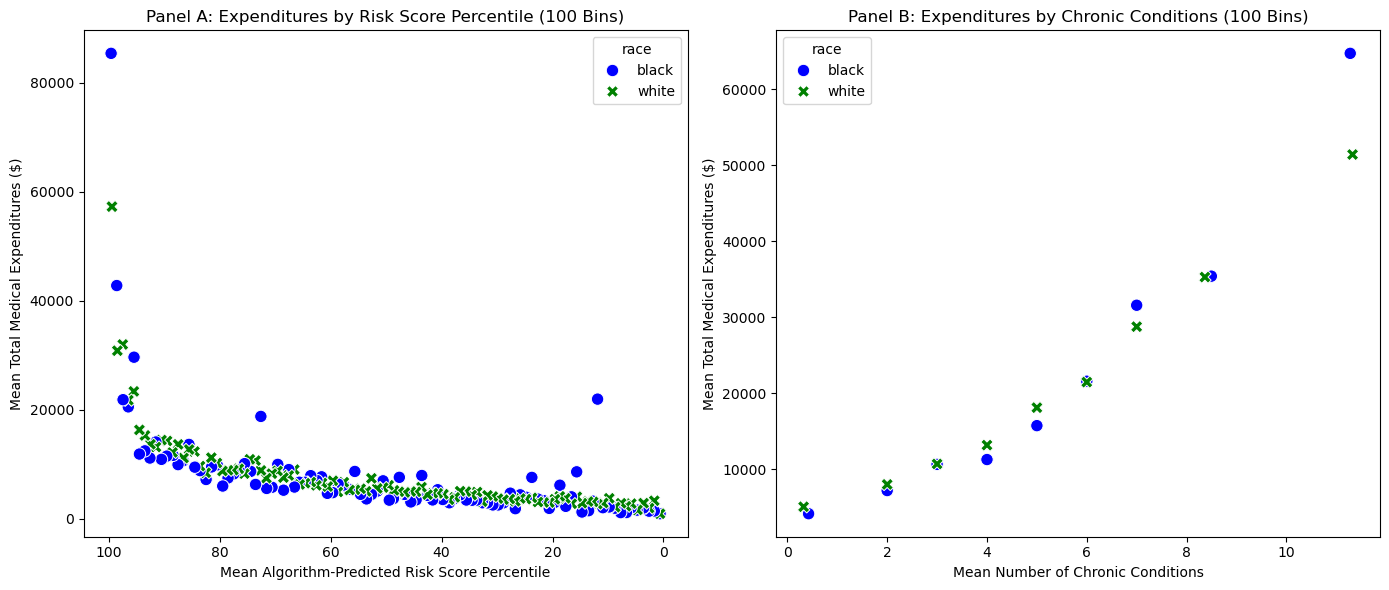

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Mean Expenditures vs. Mean Risk Percentile
sns.scatterplot(
    data=panelA,
    x='mean_risk_percentile',
    y='mean_expenditures',
    hue='race',
    style='race',
    markers={'white': 'X', 'black': 'o'},
    palette={'white': 'green', 'black': 'blue'},
    s=80,
    ax=axes[0]
)
axes[0].set_xlabel("Mean Algorithm-Predicted Risk Score Percentile")
axes[0].set_ylabel("Mean Total Medical Expenditures ($)")
axes[0].set_title("Panel A: Expenditures by Risk Score Percentile (100 Bins)")
axes[0].invert_xaxis()  # Reverse x-axis so that 100% is on the left

# Panel B: Mean Expenditures vs. Mean Chronic Conditions
sns.scatterplot(
    data=panelB,
    x='mean_chronic',
    y='mean_expenditures',
    hue='race',
    style='race',
    markers={'white': 'X', 'black': 'o'},
    palette={'white': 'green', 'black': 'blue'},
    s=80,
    ax=axes[1]
)
axes[1].set_xlabel("Mean Number of Chronic Conditions")
axes[1].set_ylabel("Mean Total Medical Expenditures ($)")
axes[1].set_title("Panel B: Expenditures by Chronic Conditions (100 Bins)")

plt.tight_layout()
plt.show()

Figure 3 reveals two critical aspects of the racial bias in this healthcare algorithm:
Panel A shows that the algorithm's risk scores are well-calibrated across races with respect to costs. At any given risk score percentile, both Black and White patients generate roughly the same healthcare expenditures. From a purely cost-prediction standpoint, the algorithm appears unbiased.
Panel B, however, tells a different story: at the same number of chronic conditions, Black patients consistently incur lower healthcare costs than White patients. This disparity is especially pronounced for patients with fewer chronic conditions (which represent the majority of patients in the dataset).
This finding illuminates the key problem: the algorithm uses cost as a proxy for health needs, but Black patients generate lower healthcare costs than White patients with the same health needs. The reasons for this disparity could include barriers to accessing care, mistrust of the healthcare system due to historical mistreatment, different treatment patterns by healthcare providers, and socioeconomic factors affecting healthcare utilization.

# Part D: Modeling Cost Disparity

## 1. Loading and Preparing the Data

We begin by importing essential statistical and machine learning libraries that will enable us to build and evaluate our regression models. Since our analysis involves logarithmic transformation, we filter out patients with zero cost records (as log(0) is mathematically undefined). We then prepare our data by creating a log-transformed cost variable and a binary indicator for race.

In [6]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
import warnings

# Keep only white or black patients
df = df[df['race'].isin(['white', 'black'])]

# Remove patients with zero cost (log(0) is undefined)
df_model = df[df['cost_t'] > 0].copy()

# Create a log-transformed cost column
df_model['log_cost'] = np.log(df_model['cost_t'])

# Race dummy: 1 if Black, 0 if White
df_model['race_dummy'] = (df_model['race'] == 'black').astype(int)

## 2. Defining Helper Functions

To properly model the relationship between health status and costs, we need to account for potential nonlinear patterns. We define two utility functions: one that standardizes variables to improve model convergence, and another that generates polynomial features to capture nonlinear relationships between chronic conditions and healthcare costs.

In [7]:
def standard_scale(series):
    return (series - series.mean()) / series.std()

def add_polynomial_features(df, degree):
    df_poly = df.copy()
    for j in range(2, degree + 1):
        df_poly[f"poly_{j}"] = df_poly["gagne_sum_t"] ** j
    return df_poly

## 3. Building the Design Matrix

This function constructs our model's input data by creating a feature matrix that captures both the health status of patients (through polynomial transformations of chronic condition counts) and their racial identity. The standardization step ensures our model doesn't favor higher-magnitude features, while the polynomial expansion allows us to detect complex patterns in how health status relates to costs.

In [8]:
def build_design_matrix(df, degree):
    df_temp = df.copy()
    
    # Standardize the predictor
    df_temp['gagne_sum_t_scaled'] = standard_scale(df_temp['gagne_sum_t'])
    
    # Rename the scaled column to 'gagne_sum_t' for polynomial generation
    df_poly_input = df_temp[['gagne_sum_t_scaled']].rename(columns={'gagne_sum_t_scaled': 'gagne_sum_t'})
    df_poly = add_polynomial_features(df_poly_input, degree)
    
    # Gather polynomial columns into a NumPy array
    poly_cols = ['gagne_sum_t'] + [f"poly_{j}" for j in range(2, degree + 1)]
    X_poly = df_poly[poly_cols].values
    
    # Append the race dummy as an extra column
    race_dummy = df_temp[['race_dummy']].values
    X = np.hstack([X_poly, race_dummy])
    
    # The target is log_cost
    y = df_temp['log_cost'].values
    
    return X, y

## 4. Cross-Validation over Degree and Alpha

To find the optimal model that balances complexity against generalizability, we perform a grid search across different polynomial degrees and regularization strengths. We employ 5-fold cross-validation to ensure our model will perform well on new data, and we track the mean squared error to identify the combination that best captures the relationship between health status, race, and healthcare costs.

In [9]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Define the search space
    degrees = range(1, 12)
    alphas = [10**k for k in range(-4, 5)]

    best_mse = np.inf
    best_degree = None
    best_alpha = None

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Search for the best degree and alpha
    for deg in degrees:
        X_all, y_all = build_design_matrix(df_model, deg)
        
        for alpha in alphas:
            ridge = Ridge(alpha=alpha)
            
            # Negative MSE is returned, so we negate it to get the actual MSE
            scores = cross_val_score(ridge, X_all, y_all, scoring='neg_mean_squared_error', cv=cv)
            mse = -np.mean(scores)
            
            if mse < best_mse:
                best_mse = mse
                best_degree = deg
                best_alpha = alpha
    
    print(f"Best polynomial degree: {best_degree}")
    print(f"Best alpha: {best_alpha}")
    print(f"Best CV MSE: {best_mse:.4f}")

Best polynomial degree: 11
Best alpha: 0.1
Best CV MSE: 1.5085


## 5. Refit the Final Model and Print Results

Using the optimal parameters identified through cross-validation, we now train our final model on the complete dataset. The coefficient for our race dummy variable directly quantifies the disparity in healthcare costs between Black and White patients after controlling for health status. Since our model uses log-transformed costs, we exponentiate and convert to a percentage to provide an intuitive interpretation of the racial disparity in healthcare spending.

In [10]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Refit using the best combination
    X_final, y_final = build_design_matrix(df_model, best_degree)
    final_ridge = Ridge(alpha=best_alpha)
    final_ridge.fit(X_final, y_final)

    # Extract the coefficient for race_dummy (last column in X_final)
    race_coef = final_ridge.coef_[-1]
    print("Coefficient for race_dummy (Black vs. White):", race_coef)

    # Interpretation in a log-cost model
    perc_diff = (np.exp(race_coef) - 1) * 100
    print(f"Estimated % difference in cost for Black vs. White patients: {perc_diff:.2f}%")

Coefficient for race_dummy (Black vs. White): -0.2668415054849388
Estimated % difference in cost for Black vs. White patients: -23.42%


After determining the optimal polynomial degree and regularization strength through cross-validation, we built a final model that reveals that Black patients incur approximately 23.42% less in healthcare costs compared to White patients with the same number and pattern of chronic conditions.
This finding strongly supports Obermeyer et al.'s argument that there is a systematic racial disparity in healthcare costs that is not explained by differences in health status. The algorithm, by using cost as a proxy for health needs, inherits this disparity and erroneously concludes that Black patients are healthier than equally sick White patients.

## Part E: Discussion

This analysis confirms the central finding of Obermeyer et al.'s 2019 paper: a widely used healthcare algorithm exhibits significant racial bias by underestimating the health needs of Black patients. By predicting future healthcare costs rather than actual illness, the algorithm systematically disadvantages Black patients who face barriers to accessing healthcare despite having similar or greater health needs compared to White patients.
Looking at the formal statistical discrimination criteria from Chapter 3 of Barocas, Hardt, and Narayanan (2023), this algorithm's bias aligns most closely with calibration bias. Calibration requires that for any score value, the predicted probability matches the actual probability of the outcome across all groups. In this case, the algorithm is well-calibrated for costs (Panel A of Figure 3 shows that at any risk score, Black and White patients have similar healthcare costs), but it fails to calibrate for actual health needs (as shown in Figure 1, where Black patients have more chronic conditions than White patients at the same risk score).

This discrepancy represents a form of representational harm, where a seemingly accurate algorithm encodes and reinforces societal inequities. By framing health risk in terms of cost rather than illness, the algorithm reproduces historical patterns of healthcare underutilization by Black patients.
This case study illustrates how algorithmic bias can emerge even without explicit discrimination or malicious intent. The bias stemmed not from explicit racial variables in the model, but from the choice of using cost as a proxy for health needs - a choice that seemed reasonable but failed to account for societal inequities in healthcare access and utilization.
The solution proposed by the researchers – modifying the algorithm to predict health needs directly rather than costs – demonstrates that addressing algorithmic bias often requires reconsidering fundamental assumptions about our data and models rather than simply removing sensitive attributes or adjusting technical parameters.